In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("amazon_final.csv")

In [4]:
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,OrderID,OrderDate,CustomerID,ProductID,ProductName,Category,Brand,...,TotalAmount,OrderStatus,Country,SellerID,Total Sales,OrderYear,OrderMonth,Tax Ratio,Tax Category,Shipping to Price Ratio
0,0,0,0,ORD0000001,2023-01-31,CUST001504,P00014,Drone Mini,Books,BrightLux,...,319.86,Delivered,India,SELL01967,320.0400,2023,1,0.000000,Low,0.000281
1,1,1,1,ORD0000002,2023-12-30,CUST000178,P00040,Microphone,Home & Kitchen,UrbanStyle,...,259.64,Delivered,United States,SELL01298,259.6415,2023,12,0.075984,Low,0.006922
2,2,2,2,ORD0000003,2022-05-10,CUST047516,P00044,Power Bank 20000mAh,Clothing,UrbanStyle,...,108.06,Delivered,United States,SELL00908,135.0210,2022,5,0.072033,Low,0.056238
3,3,3,3,ORD0000004,2023-07-18,CUST030059,P00041,Webcam Full HD,Home & Kitchen,Zenith,...,159.66,Delivered,India,SELL01164,227.4650,2023,7,0.068017,Low,0.032936
4,4,4,4,ORD0000005,2023-02-04,CUST048677,P00029,T-Shirt,Clothing,KiddoFun,...,821.36,Cancelled,Canada,SELL01411,869.2600,2023,2,0.037497,Low,0.008950


## Stat Aggregation


In [5]:
unit_price = df["UnitPrice"]
tax = df["Tax"]
shipping = df["ShippingCost"]
disc = df["Discount"]
total_sale_price = (unit_price + tax+ shipping) - (unit_price * disc)
df["Total Sales"] = df["Quantity"] * total_sale_price

#### What is the total amount of Sales?

In [42]:
sum_of_sales = df["Total Sales"].sum()
print(f"{float(sum_of_sales)} in dollars")

111612088.9935 in dollars


#### How many unique customers are there?


In [7]:
unique_customers = df["CustomerID"].unique()
len(unique_customers)

43233

#### What are the total numbers of products sold?


In [8]:
len(df["OrderID"])

100000

## Time-based Trend Identification

In [9]:
#split based on year
def get_year(date_str):
    return int(date_str.split("-")[0])

def get_month(date_str):
    return int(date_str.split("-")[1])


df["OrderYear"] = df["OrderDate"].apply(lambda x : get_year(x))
df["OrderMonth"] = df["OrderDate"].apply(lambda x : get_month(x))

In [10]:
def pivot_by_year(df : pd.DataFrame, year : int):
    year_df = df[df["OrderYear"] == year]
    return pd.pivot_table(year_df, index=["OrderYear", "OrderMonth"], columns=["Category"], values=["Total Sales"], aggfunc="sum")


In [11]:
year_pvt = pivot_by_year(df, 2021)

#### How do Sales Revenue Change by month of Year, and how does the trend shift each year?


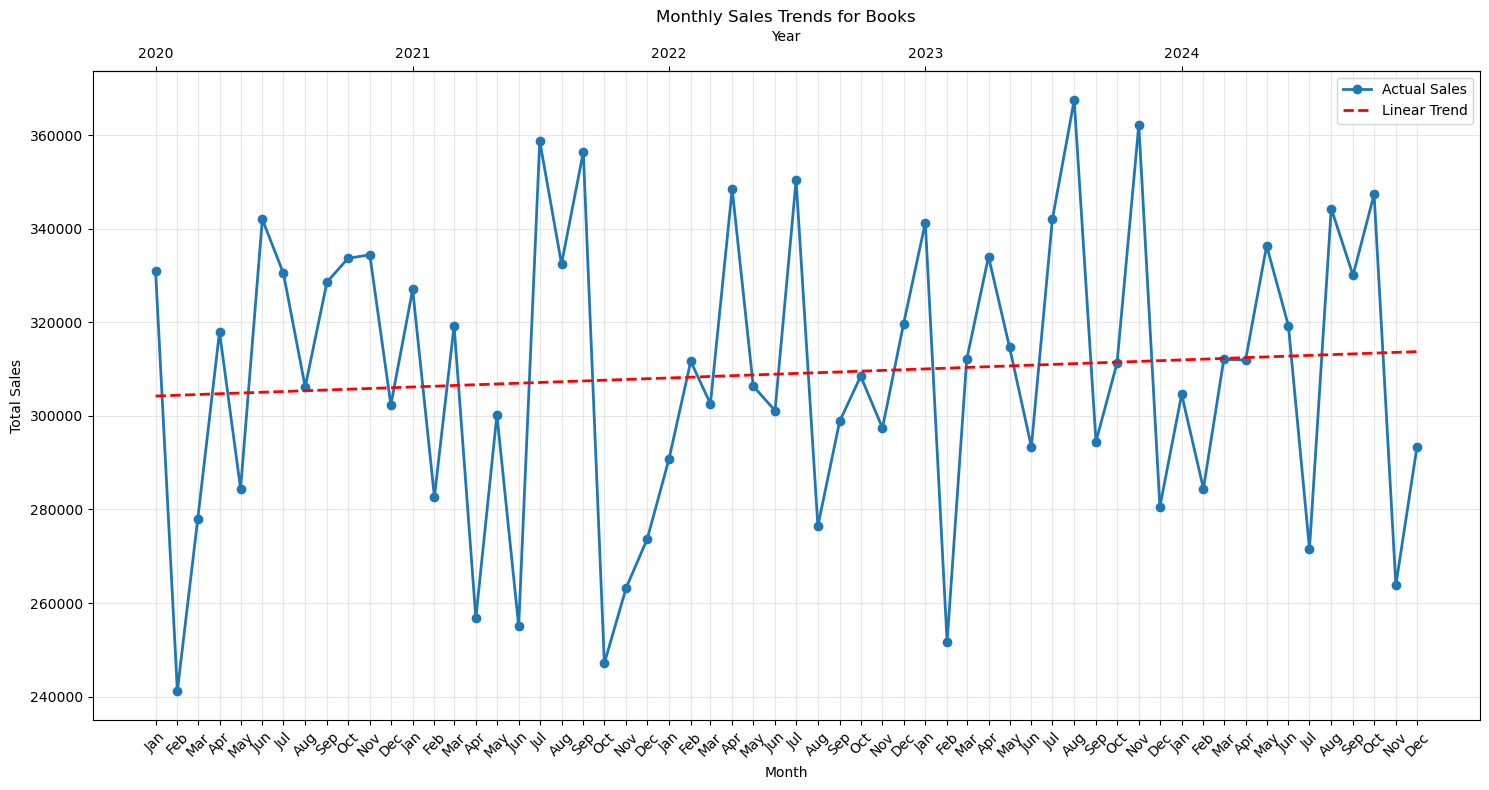


Books - Linear Trend Results:
Intercept: 304105.34
Slope: 160.8772
Slope 95% CI: [-302.43218889420166, 624.1865818644707]


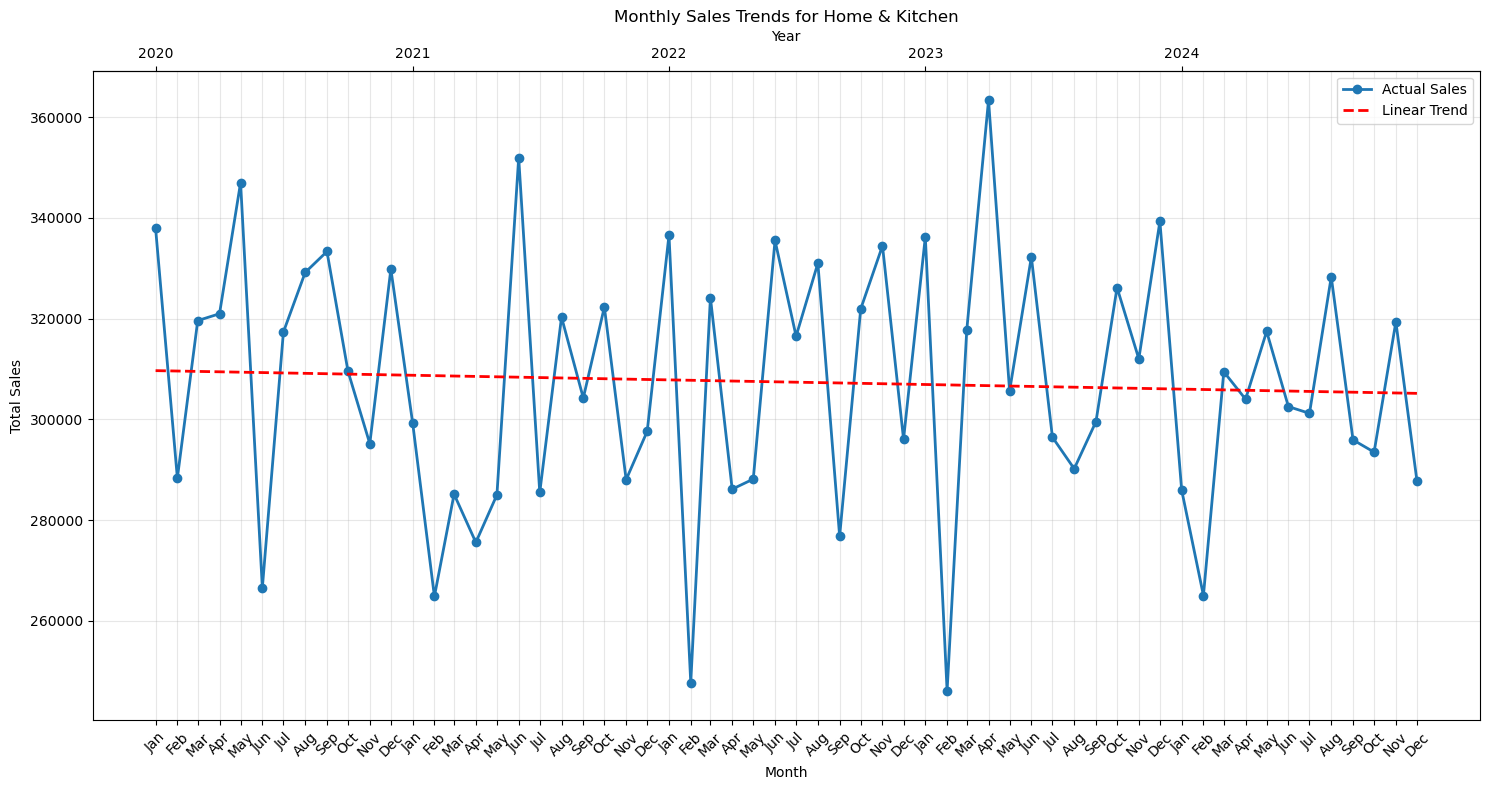


Home & Kitchen - Linear Trend Results:
Intercept: 309739.30
Slope: -76.4134
Slope 95% CI: [-452.6628546730697, 299.8360946563982]


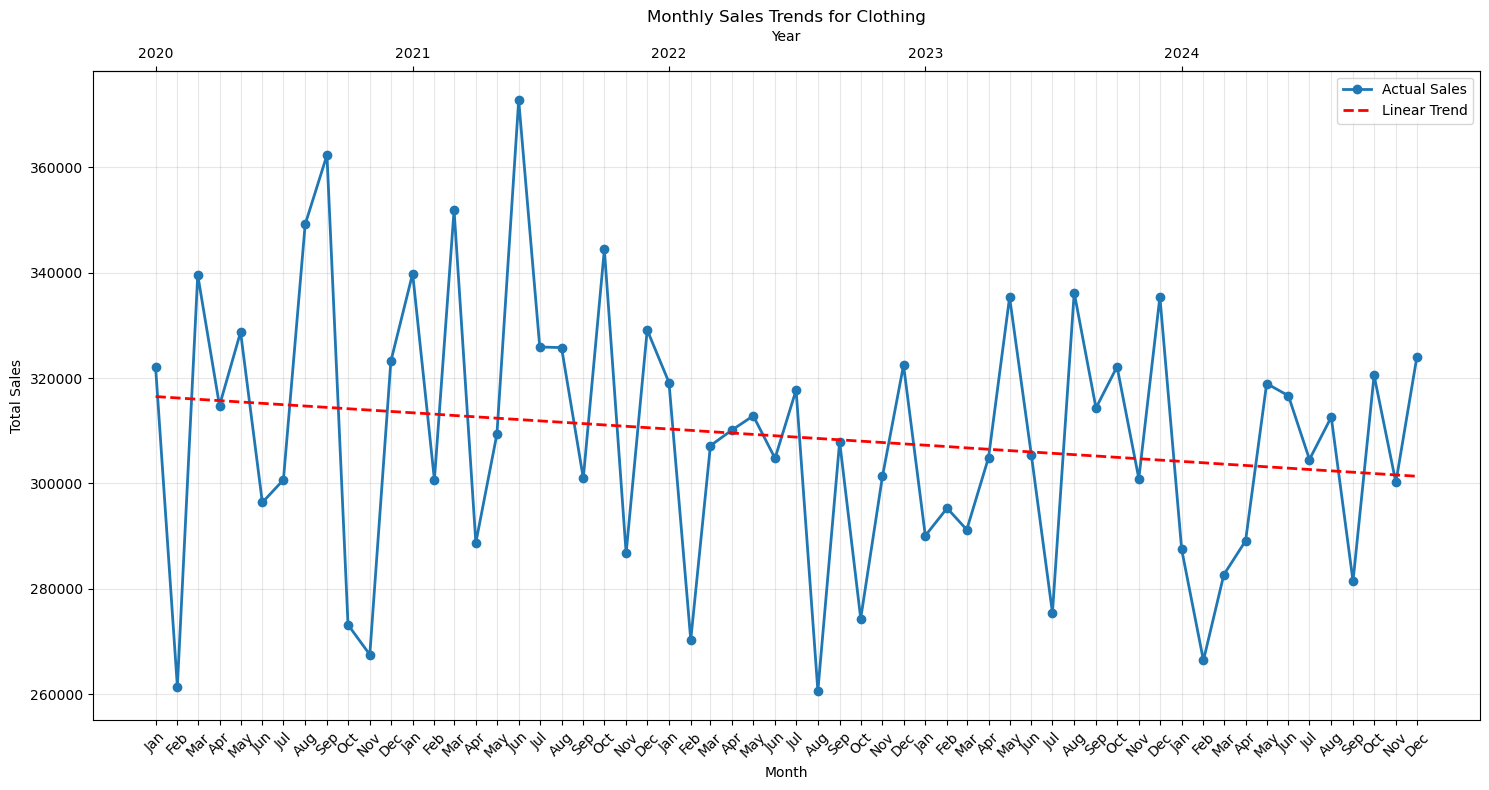


Clothing - Linear Trend Results:
Intercept: 316740.10
Slope: -256.1456
Slope 95% CI: [-623.9121667618363, 111.62100452232511]


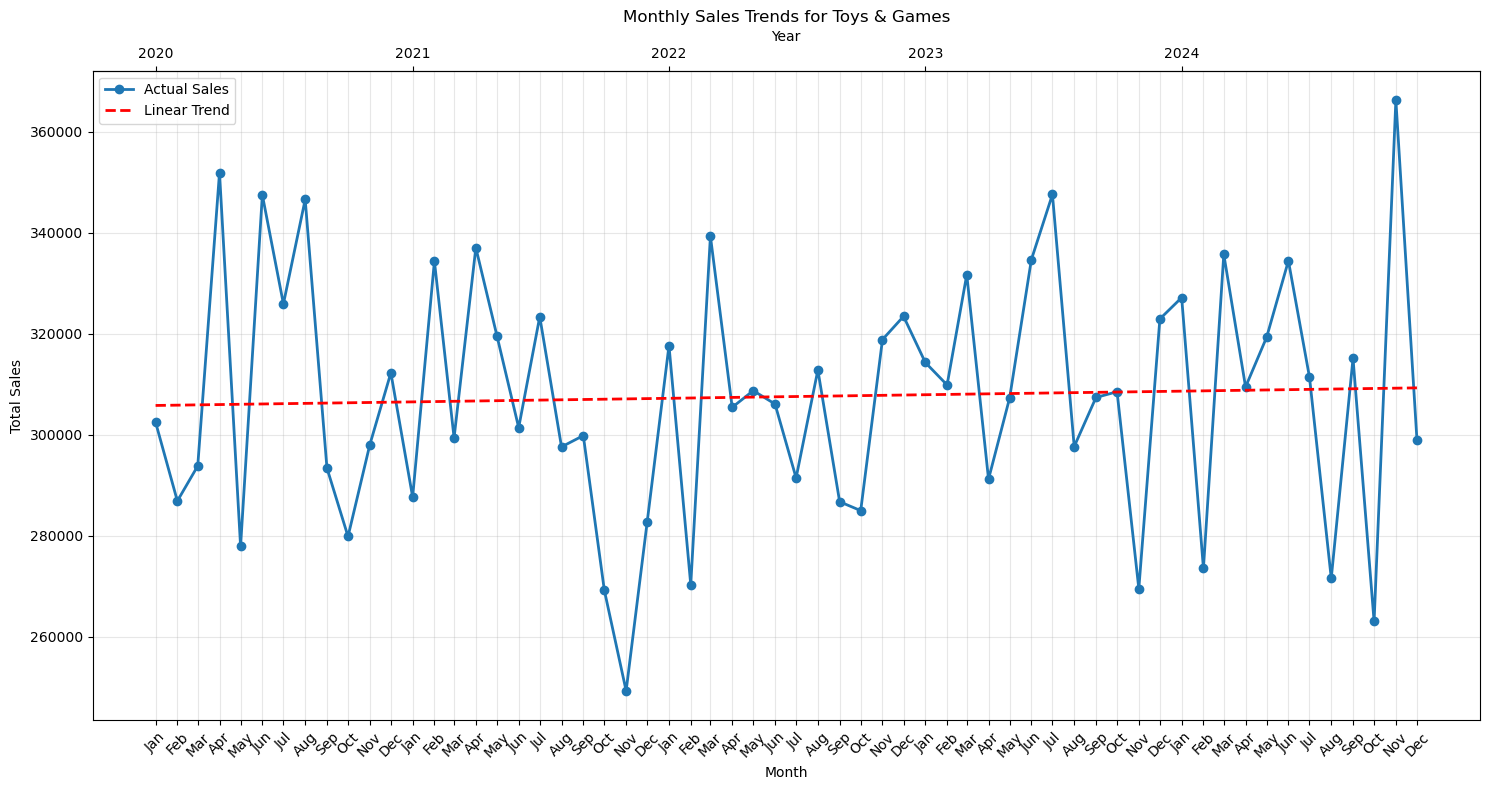


Toys & Games - Linear Trend Results:
Intercept: 305748.11
Slope: 59.0589
Slope 95% CI: [-309.2737861744164, 427.39152585210377]


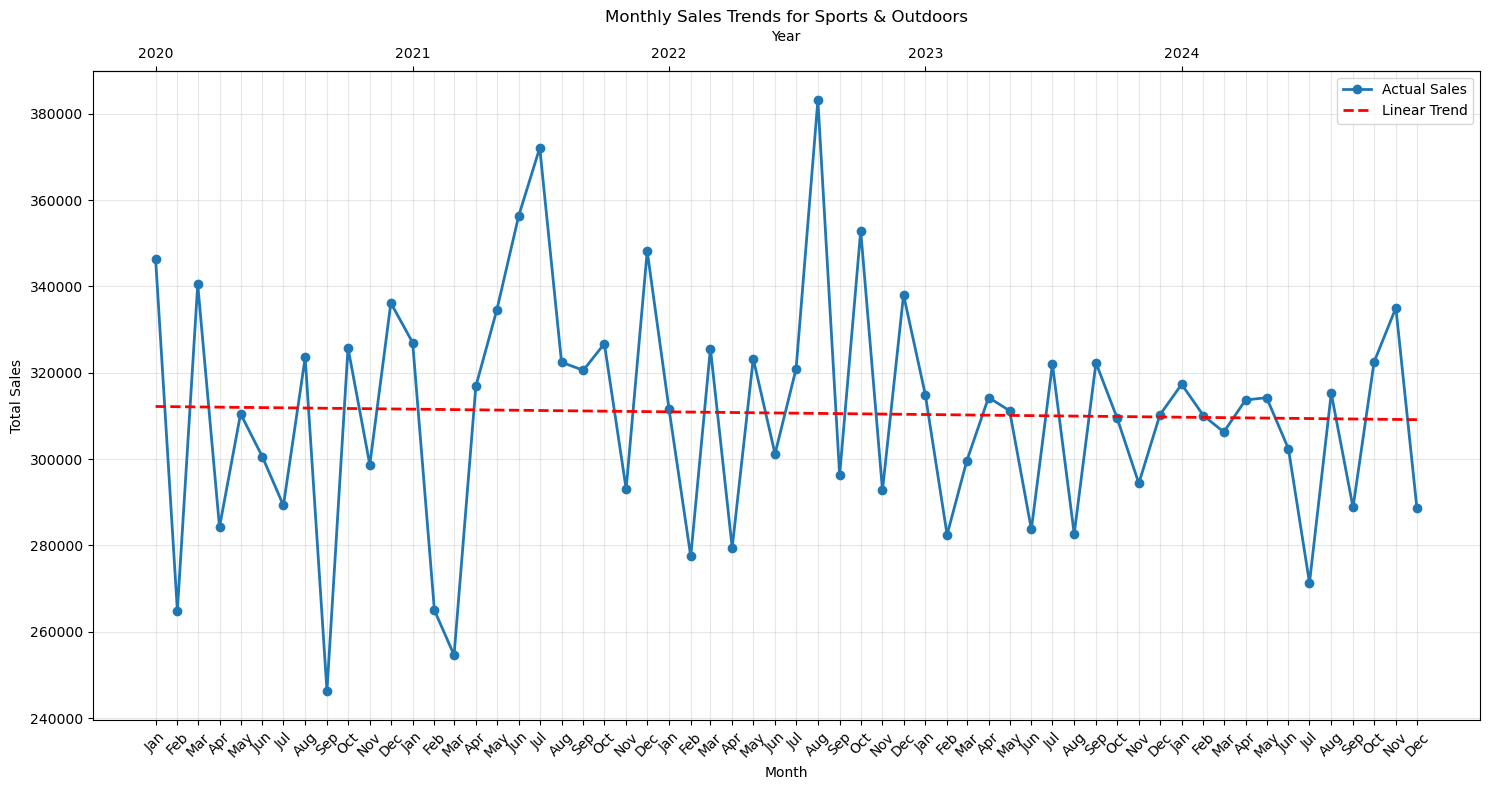


Sports & Outdoors - Linear Trend Results:
Intercept: 312235.13
Slope: -51.7162
Slope 95% CI: [-454.9676724270177, 351.5352185509393]


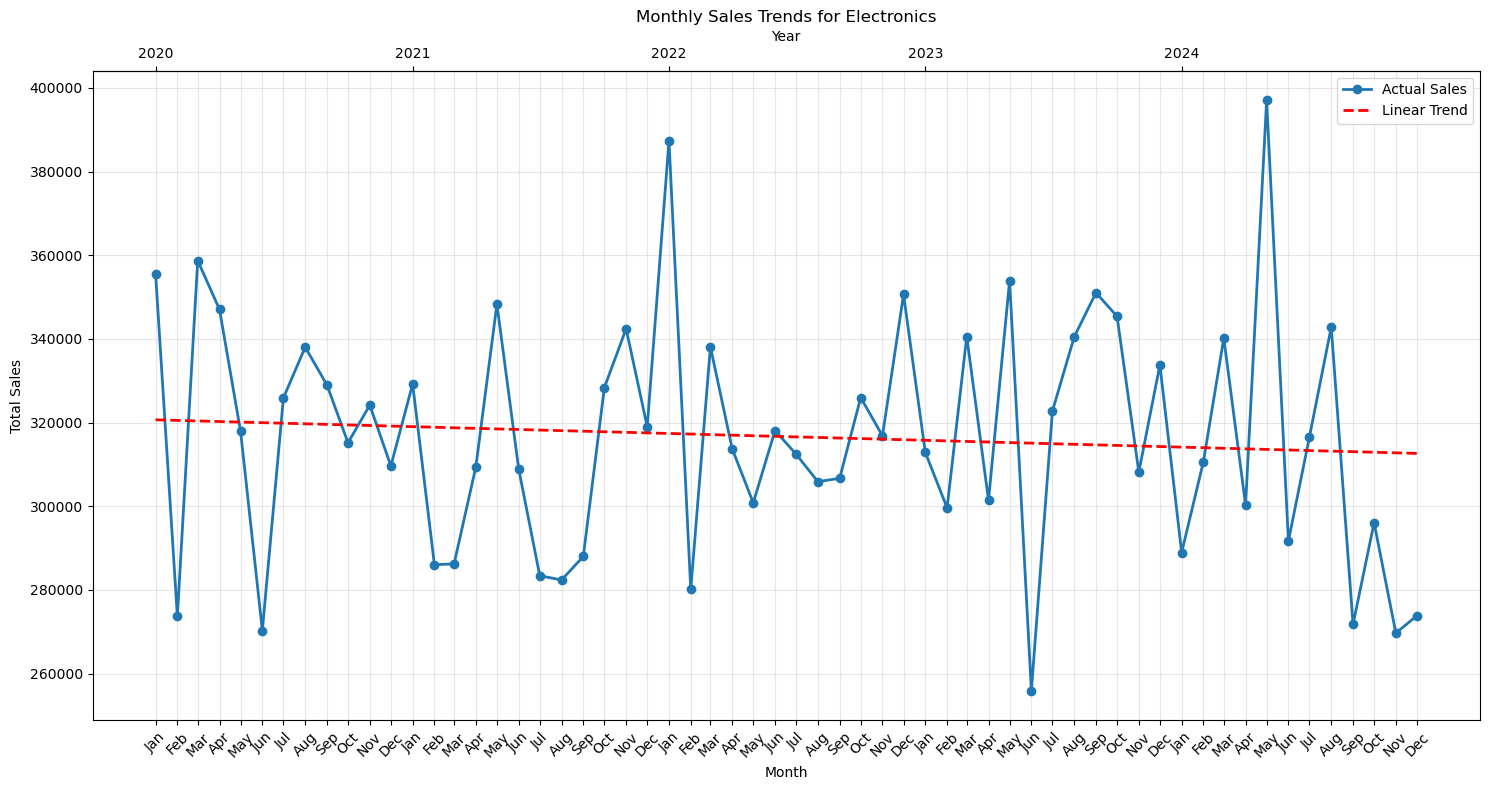


Electronics - Linear Trend Results:
Intercept: 320795.28
Slope: -136.0472
Slope 95% CI: [-571.1072101527441, 299.01271173651963]


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

categories = df['Category'].unique()


def reshape_dataset(df, base_year=2020):
    """
    Flatten years so months are continuous across multiple years
    """
    reshaped = df.copy()
    reshaped["Month_flat"] = (reshaped["OrderYear"] - base_year) * 12 + reshaped["OrderMonth"]
    return reshaped[["Total Sales", "Month_flat"]]


def calculate_linear_trend_statsmodels(x, y):
    """
    Fit OLS regression with statsmodels and calculate MAE
    """
    # Add intercept term
    X = sm.add_constant(x)
    
    # Fit OLS
    model = sm.OLS(y, X).fit()
    
    # Predicted values
    y_pred = model.predict(X)
    
    # MAE
    mae = mean_absolute_error(y, y_pred)
    
    # Extract slope and intercept
    intercept = model.params[0]
    slope = model.params[1]
    conf_int = model.conf_int()[1].tolist()  # slope CI
    
    return {
        "intercept": intercept,
        "slope": slope,
        "slope_ci": conf_int,
        "mae": mae,
        "model": model
    }


for category in categories:
    category_data = df[df['Category'] == category]

    # Aggregate monthly sales
    category_monthly = (
        category_data
        .groupby(['OrderYear', 'OrderMonth'], as_index=False)['Total Sales']
        .sum()
    )

    # Create datetime for plotting
    category_monthly['Date'] = pd.to_datetime(
        category_monthly['OrderYear'].astype(str) + '-' +
        category_monthly['OrderMonth'].astype(str) + '-01'
    )
    category_monthly = category_monthly.sort_values('Date')

    # Flatten months for regression
    category_monthly_reg_data = category_monthly[["Total Sales", "OrderMonth", "OrderYear"]]
    reshaped = reshape_dataset(category_monthly_reg_data)
    
    x = reshaped["Month_flat"].values
    y = reshaped["Total Sales"].values

    # Fit linear trend with statsmodels
    trend_results = calculate_linear_trend_statsmodels(x, y)

    # ---- Plotting ----
    fig, ax = plt.subplots(figsize=(15, 8))

    # Actual sales
    ax.plot(
        category_monthly['Date'],
        category_monthly['Total Sales'],
        marker='o',
        linewidth=2,
        label='Actual Sales'
    )

    # Trend line
    trend_line = trend_results['intercept'] + trend_results['slope'] * x
    ax.plot(
        category_monthly['Date'],
        trend_line,
        '--',
        color='red',
        linewidth=2,
        label=f'Linear Trend'
    )

    ax.set_xlabel('Month')
    ax.set_ylabel('Total Sales')
    ax.set_title(f'Monthly Sales Trends for {category}')
    ax.grid(alpha=0.3)
    ax.legend()

    # Bottom axis: months
    ax.set_xticks(category_monthly['Date'])
    ax.set_xticklabels(
        category_monthly['Date'].dt.strftime('%b'),
        rotation=45
    )

    # Top axis: years
    ax_top = ax.secondary_xaxis('top')
    year_ticks = category_monthly.groupby('OrderYear')['Date'].first()
    ax_top.set_xticks(year_ticks.values)
    ax_top.set_xticklabels(year_ticks.index.astype(str))
    ax_top.set_xlabel('Year')

    plt.tight_layout()
    plt.show()
    # ---- Print results ----
    print(f"\n{category} - Linear Trend Results:")
    print(f"Intercept: {trend_results['intercept']:.2f}")
    print(f"Slope: {trend_results['slope']:.4f}")
    print(f"Slope 95% CI: {trend_results['slope_ci']}")
    


####

#### Analysis


- Visual inspection shows sales data fluctuate widely, with no obvious clusters or cyclin patterns around common cutoff points like quarter- or year-end, suggesting the series is noisy.

- Most categories (Books, Home & Kitchen, Toys & Games, and Sports & Outdoors) show very weak slopes relative to the magnitude of the sales data, while Clothing exhibits a steeper downward slope.

- Examining the 95% confidence intervals reveals that all slopes include zero, meaning none of the observed trends are statistically significant at the p < 0.05 level (there is a more than 5% probability that any observed differences are not meaningful statistically and are just random fluctuations).

- Based on the evidence that shown the visual patterns and regression analysis indicate that no meaningful trend can be reliably inferred.


## Visualize Inter-variable Relationships


In [70]:
#tax category and products
def plot_distribution_by_selector(target : str, selector: str, color_map=None, chart_type = "Bar") -> None:
    for s in df[selector].unique():
        selector_df = df[df[selector] == s]
        target_counts = selector_df[target].value_counts()
        plt.figure(figsize=(12, 6))
        plt.title(f"Amount of {target} goods per {selector}: {s}")
                
        # Use color mapping if provided, otherwise default colors
        if color_map:
            colors = [color_map.get(cat, 'blue') for cat in target_counts.index]
            plt.bar(target_counts.index, target_counts.values, color=colors, width=0.6)
        else:
            plt.bar(target_counts.index, target_counts.values, width=0.6)
        
        plt.show()



### Region and Products


#### How many products does each country buy for each category? and what proportion?

<Figure size 1400x800 with 0 Axes>

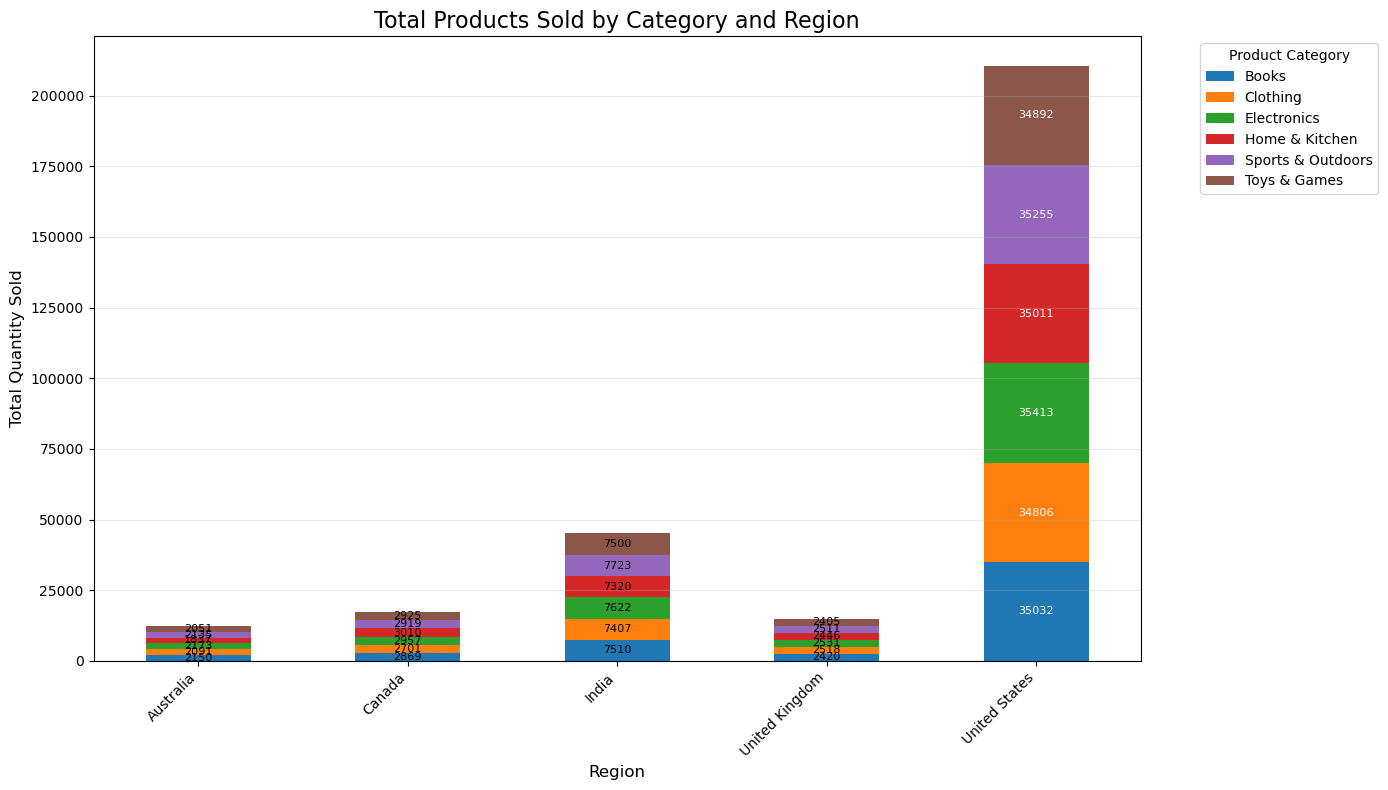

Category totals by region:
Category        Books  Clothing  Electronics  Home & Kitchen  \
Region                                                         
Australia        2150      2091         2173            1837   
Canada           2869      2701         2957            3010   
India            7510      7407         7622            7320   
United Kingdom   2420      2518         2531            2446   
United States   35032     34806        35413           35011   

Category        Sports & Outdoors  Toys & Games  
Region                                           
Australia                    2135          2051  
Canada                       2919          2925  
India                        7723          7500  
United Kingdom               2511          2405  
United States               35255         34892  


In [16]:
# Create stacked bar plot of product categories by region
import matplotlib.pyplot as plt

df_copy = df.copy()
df_copy['Region'] = df_copy['Country']

category_region = df_copy.groupby(['Region', 'Category'])['Quantity'].sum().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
category_region.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.title('Total Products Sold by Category and Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')

for i, region in enumerate(category_region.index):
    y_offset = 0
    for category in category_region.columns:
        value = category_region.loc[region, category]
        if value > 0:
            plt.text(i, y_offset + value/2, str(int(value)), 
                    ha='center', va='center', fontsize=8, color='white' if value > category_region.sum(axis=1).max()/10 else 'black')
        y_offset += value

plt.show()

# Display the data table
print("Category totals by region:")
print(category_region)

##### Analysis

- Due to the dominant amount of customers from the US, there are far more products being sold to the United States.

- It can be seen that accross all countries, the proportion of items sold is quite even for each category, no matter the total amount of products sold.

## Customer Segmentation


#### Which countries copntain the most customers?

In [17]:
##plot distribution of brand vs product category
df["Country"].value_counts()

Country
United States     70058
India             15051
Canada             5818
United Kingdom     4943
Australia          4130
Name: count, dtype: int64

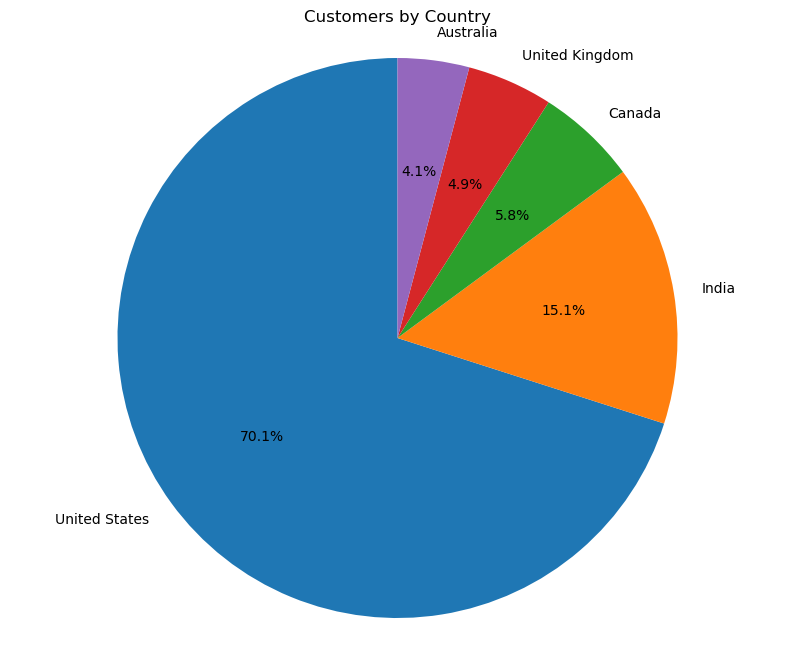

Customer counts by country:
Country
United States     70058
India             15051
Canada             5818
United Kingdom     4943
Australia          4130
Name: count, dtype: int64


In [18]:
import matplotlib.pyplot as plt

# Count customers by country
country_counts = df['Country'].value_counts()

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(country_counts.values, labels=country_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customers by Country')
plt.axis('equal')
plt.show()

# Display the counts
print("Customer counts by country:")
print(country_counts)

#### How much do countries spend on average per year?

In [19]:
country_pivot = pd.pivot_table(
    df,
    index="Country",
    columns="OrderYear",
    values="Total Sales",   
    aggfunc="mean"           
)


In [20]:
country_pivot

OrderYear,2020,2021,2022,2023,2024
Country,,,,,
Australia,1135.498261,1155.770837,1103.799353,1128.115826,1063.502681
Canada,1081.821355,1134.959384,1129.390808,1112.819224,1090.699599
India,1137.326978,1098.373467,1092.848712,1137.414216,1135.765690
United Kingdom,1072.900378,1066.442449,1132.943826,1131.524279,1159.231858
United States,1124.706819,1117.999443,1114.874656,1117.454669,1104.394440


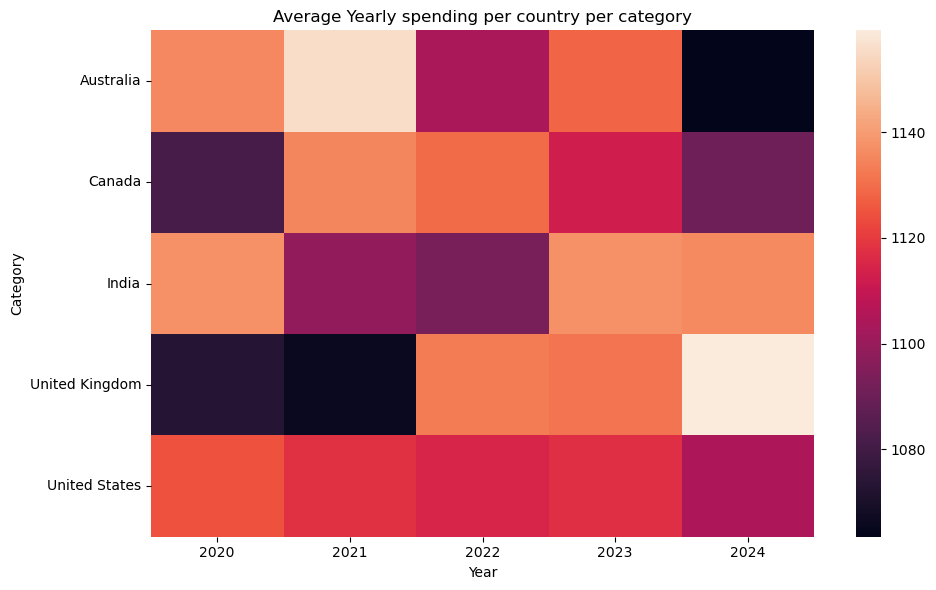

In [21]:
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.heatmap(
    country_pivot,
)
plt.title("Average Yearly spending per country per category")
plt.ylabel("Category")
plt.xlabel("Year")
plt.tight_layout()
plt.show()
plt.close()



In [40]:
for country in country_pivot.index:
    country_spendings = country_pivot.loc[country]
    avg_spending = country_spendings.mean()
    
    print(f"{country}:")
    print(f"  Yearly spendings: {country_spendings.values}")
    print(f"  Average spending across all years: {avg_spending:.2f}")
    print()

# Overall average spending across all countries and years
overall_avg = country_pivot.values.mean()


Australia:
  Yearly spendings: [1135.49826136 1155.77083689 1103.79935277 1128.11582574 1063.50268142]
  Average spending across all years: 1117.34

Canada:
  Yearly spendings: [1081.82135507 1134.95938439 1129.39080835 1112.81922373 1090.69959865]
  Average spending across all years: 1109.94

India:
  Yearly spendings: [1137.32697805 1098.37346653 1092.84871241 1137.41421594 1135.76568982]
  Average spending across all years: 1120.35

United Kingdom:
  Yearly spendings: [1072.90037769 1066.44244897 1132.94382626 1131.52427949 1159.23185784]
  Average spending across all years: 1112.61

United States:
  Yearly spendings: [1124.70681926 1117.99944283 1114.87465636 1117.45466875 1104.39443977]
  Average spending across all years: 1115.89



#### Analysis
- The averagee spending accross all countries throughout the years are very similiar
- Despite dominance in sales numbers , American spendings on average is no higher than other countries and can be seen to be decreasing steadily throughout the years.
- United Kingdom spendings can be seen slightly increasing year by year, opposite to the trend of American spending
- Canadian spending sees a slight increase then drops down again steadily

- More Importantly, these yearly fluctuations are only a few dollars in change, and s trend cannot be reliably inferred from this alone


#### How  does the customer base grow each year?


In [23]:
def calculate_customer_growth_per_year(df : pd.DataFrame, year : int):
   
    if year == 2020:
        print("Base year cannot be compared")
        return
    
    df_curr_year = df[df["OrderYear"] == year]
    df_last_year = df[df["OrderYear"] == (year-1)]

    unique_customers_this_year = set(df_curr_year["CustomerID"].unique())
    unique_customers_last_year = set(df_last_year["CustomerID"].unique())

    lost = list(unique_customers_last_year - unique_customers_this_year)
    gained = list(unique_customers_this_year - unique_customers_last_year)

    # Get customer data without duplicates - keep first occurrence of each CustomerID
    cust_lost_df = df[df["CustomerID"].isin(lost)].drop_duplicates(subset=['CustomerID'], keep='first')
    cust_gained_df = df[df["CustomerID"].isin(gained)].drop_duplicates(subset=['CustomerID'], keep='first')

    return cust_gained_df[["CustomerID", "Country"]], cust_lost_df[["CustomerID", "Country"]]
    
cust_gained, cust_lost = calculate_customer_growth_per_year(df, 2021)

In [24]:
cust_lost

,CustomerID,Country
6,CUST037667,Australia
9,CUST029472,United States
12,CUST026576,United States
14,CUST025111,United States
19,CUST046893,United States
...,...,...
99877,CUST034278,United States
99895,CUST008201,United States
99904,CUST033833,United States
99965,CUST030828,United States


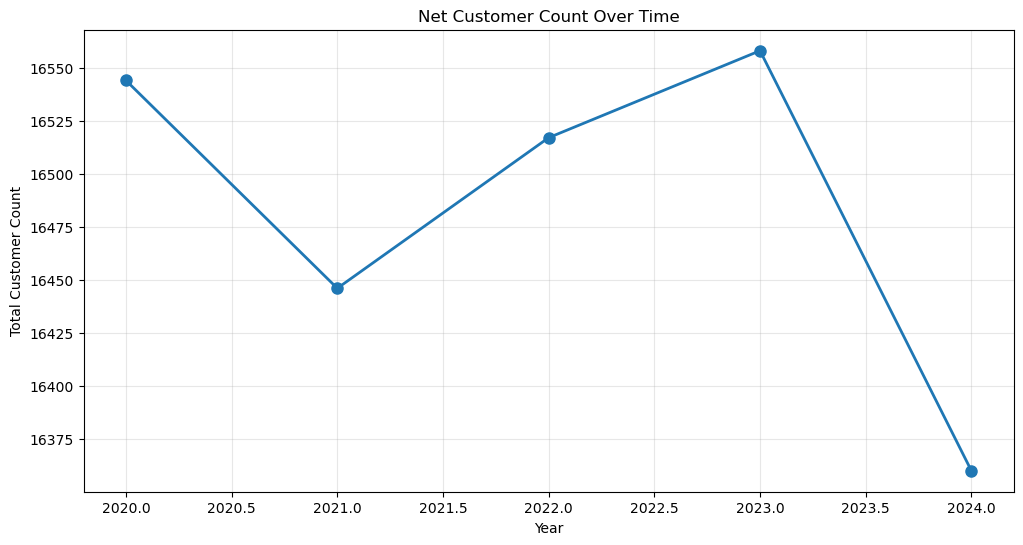

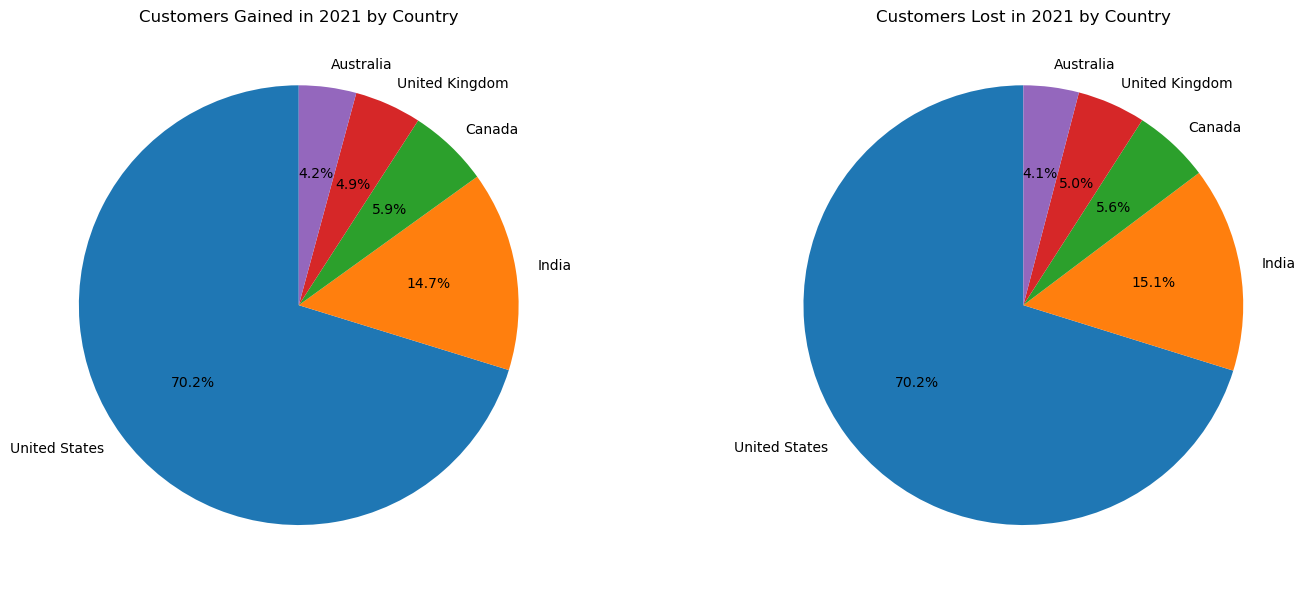


2021 Summary:
Customers gained: 10958
Customers lost: 11056
Net change: -98
Total customers: 16446


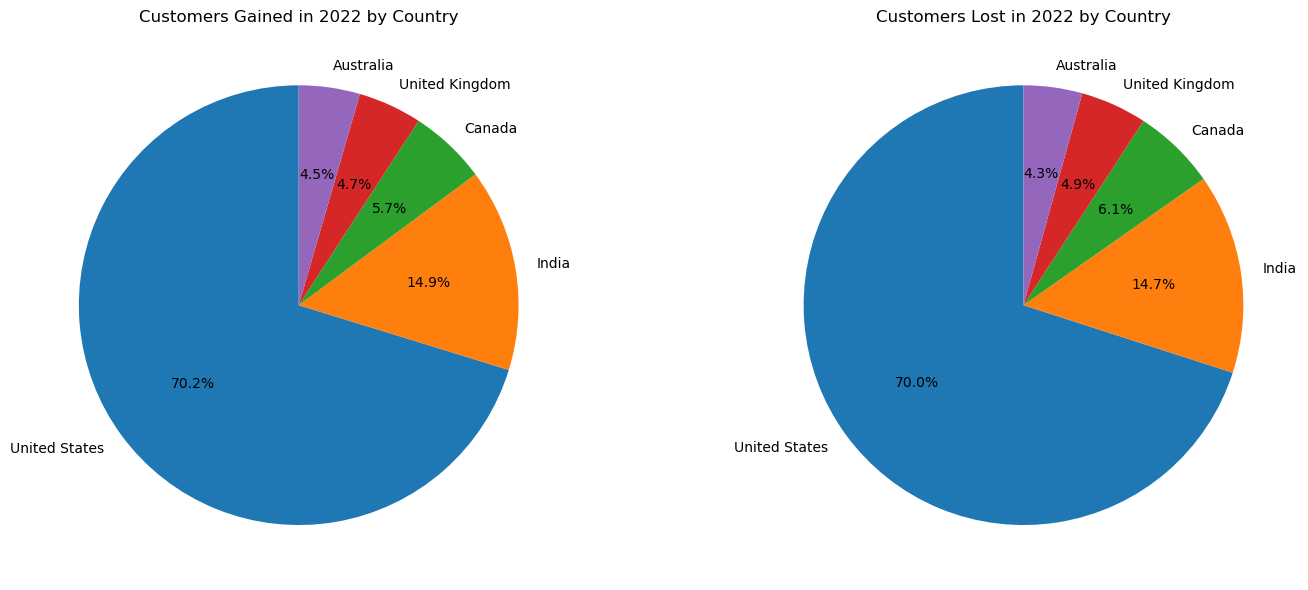


2022 Summary:
Customers gained: 11025
Customers lost: 10954
Net change: 71
Total customers: 16517


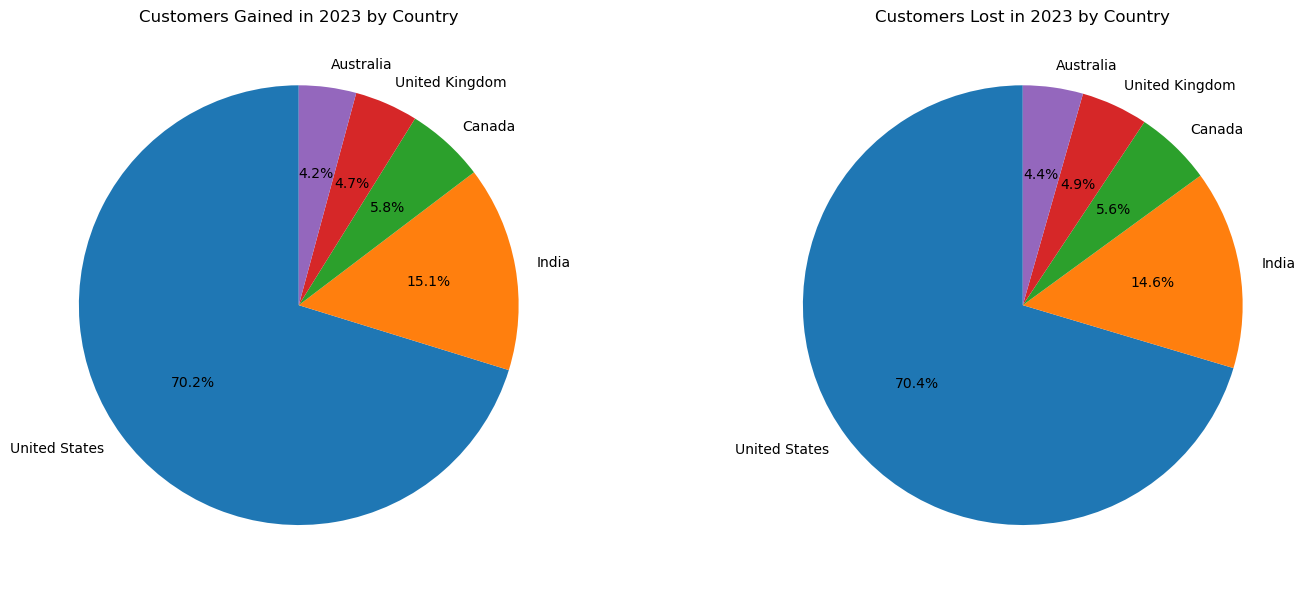


2023 Summary:
Customers gained: 11115
Customers lost: 11074
Net change: 41
Total customers: 16558


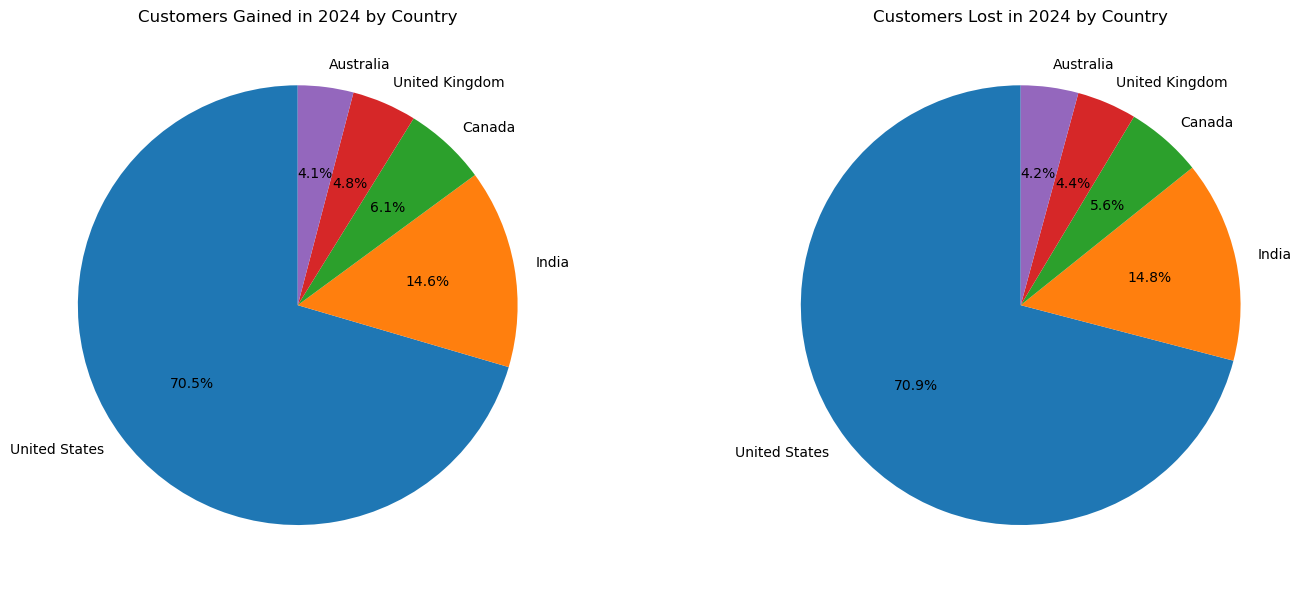


2024 Summary:
Customers gained: 10926
Customers lost: 11124
Net change: -198
Total customers: 16360


In [43]:
initial_customer_count = len(df[df["OrderYear"] == 2020]["CustomerID"].unique())
years = sorted(df["OrderYear"].unique())

# Track customer counts over time
customer_counts = {2020: initial_customer_count}
current_customers = set(df[df["OrderYear"] == 2020]["CustomerID"].unique())

unique_customer_dict = {}

for year in years[1:]:
    cust_gained, cust_lost = calculate_customer_growth_per_year(df, year)

    unique_customer_dict[f"{year}"] = cust_gained["CustomerID"].unique()
    # Update customer set
    gained_customers = set(cust_gained["CustomerID"].unique())
    lost_customers = set(cust_lost["CustomerID"].unique())
    
    current_customers = (current_customers - lost_customers) | gained_customers
    customer_counts[year] = len(current_customers)

# Plot net customer count over time
plt.figure(figsize=(12, 6))
plt.plot(list(customer_counts.keys()), list(customer_counts.values()), marker='o', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Total Customer Count')
plt.title('Net Customer Count Over Time')
plt.grid(True, alpha=0.3)
plt.show()

# Create pie charts for each year (except 2020 as base year)
for year in years[1:]:
    cust_gained, cust_lost = calculate_customer_growth_per_year(df, year)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pie chart for gained customers by country
    if not cust_gained.empty:
        gained_by_country = cust_gained['Country'].value_counts()
        ax1.pie(gained_by_country.values, labels=gained_by_country.index, autopct='%1.1f%%', startangle=90)
        ax1.set_title(f'Customers Gained in {year} by Country')
    else:
        ax1.text(0.5, 0.5, 'No customers gained', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title(f'Customers Gained in {year} by Country')
    
    # Pie chart for lost customers by country
    if not cust_lost.empty:
        lost_by_country = cust_lost['Country'].value_counts()
        ax2.pie(lost_by_country.values, labels=lost_by_country.index, autopct='%1.1f%%', startangle=90)
        ax2.set_title(f'Customers Lost in {year} by Country')
    else:
        ax2.text(0.5, 0.5, 'No customers lost', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title(f'Customers Lost in {year} by Country')
    
    plt.tight_layout()
    plt.show()
    # Print summary stats
    print(f"\n{year} Summary:")
    print(f"Customers gained: {len(cust_gained)}")
    print(f"Customers lost: {len(cust_lost)}")
    print(f"Net change: {len(cust_gained) - len(cust_lost)}")
    print(f"Total customers: {customer_counts[year]}")

#### What is the retention rate of customers? how long are customers absent on average?

In [ ]:
import pandas as pd

# Ensure OrderDate is datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Extract year from OrderDate
df['OrderYear'] = df['OrderDate'].dt.year

# Sort by CustomerID and OrderDate
df_sorted = df.sort_values(['CustomerID', 'OrderDate', 'OrderYear'])
print("Sorted DataFrame:")

# Calculate gap between orders per customer
df_sorted['OrderGap'] = df_sorted.groupby('CustomerID')['OrderDate'].diff().dt.days

# Fill NaN gaps (first order) with difference from max date
max_date = df_sorted['OrderDate'].max()
df_sorted['OrderGap'] = df_sorted['OrderGap'].fillna((max_date - df_sorted['OrderDate']).dt.days)

# Compute customer-level stats
customer_gap_stats = df_sorted.groupby('CustomerID')['OrderGap'].agg(
    ['mean', 'median', 'count']
).reset_index()

# Rename columns
customer_gap_stats.rename(
    columns={
        'mean': 'AvgAbsenceDays',
        'median': 'MedianAbsenceDays',
        'count': 'NumOrders'
    },
    inplace=True
)

# Add a ReturningCustomer column
customer_gap_stats['ReturningCustomer'] = customer_gap_stats['NumOrders'] > 1


# Count unique customers per year
customers_per_year = df.groupby('OrderYear')['CustomerID'].nunique().reset_index()
customers_per_year.rename(columns={'CustomerID': 'NumCustomers'}, inplace=True)

# Total unique customers across all years
total_customers = df['CustomerID'].nunique()

# Compute proportion of total customers per year
customers_per_year['Proportion'] = customers_per_year['NumCustomers'] / total_customers

print("\nProportion of Customers per Year:")
print(customers_per_year)


customer_years = df.groupby('CustomerID')['OrderYear'].nunique().reset_index()
customer_years.rename(columns={'OrderYear': 'NumYearsShopped'}, inplace=True)

# Identify customers who shopped in every year
customer_years['ShoppedEveryYear'] = customer_years['NumYearsShopped'] == 5

# Compute proportion relative to all customers

Sorted DataFrame:

Proportion of Customers per Year:
   OrderYear  NumCustomers  Proportion
0       2020         16544    0.382671
1       2021         16446    0.380404
2       2022         16517    0.382046
3       2023         16558    0.382994
4       2024         16360    0.378415
Proportion of customers who shopped in every year: 0.45%


In [82]:
customer_years

,CustomerID,NumYearsShopped,ShoppedEveryYear
0,CUST000001,1,False
1,CUST000002,3,False
2,CUST000003,1,False
3,CUST000004,2,False
4,CUST000005,1,False
...,...,...,...
43228,CUST049995,2,False
43229,CUST049996,1,False
43230,CUST049997,1,False
43231,CUST049998,1,False


In [ ]:
import math

returning_customers = customer_gap_stats[customer_gap_stats["ReturningCustomer"] == True]
retention_rate = len(returning_customers) * 100/ len(customer_gap_stats)
average_orders = customer_gap_stats["NumOrders"].mean()
avg_absence_length = customer_gap_stats["AvgAbsenceDays"].mean() 
median_absence_length = customer_gap_stats["AvgAbsenceDays"].median()  

proportion_every_year = len(customer_years[customer_years["ShoppedEveryYear"]] ) / len(customer_years)

print(f"percentage of returning users : {round(retention_rate, 2)}%")
print(f"average number of order by users : {math.floor(average_orders)}")
print(f"average mean absence days by users : {math.floor(avg_absence_length)}")
print(f"median number of absence days by users : {math.floor(median_absence_length)}")
print(f"Proportion of customers who shopped in every year: {proportion_every_year:.2%}")

percentage of returning users : 68.7%
average number of order by users : 2
average mean absence days by users : 826
median number of absence days by users : 778
Proportion of customers who shopped in every year: 0.45%


##### Analysis

- Each country loses an approximate amount of customers at similiar proportion each years
- Customer loyalty from one year to another is non-existent, as users come back typically after 2 years of absence
- Very few customers shopped for all five years
